In [4]:
import pandas as pd
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise import KNNWithMeans
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
import numpy as np
from nltk.stem import LancasterStemmer
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import nltk

In [5]:
books_df = pd.read_csv('./books.csv', sep=',')
books_df.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780000e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780000e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780000e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780000e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780000e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [6]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   book_id                    10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

In [7]:
## first we will be taking the needed cols
books_df = books_df[["id","book_id","books_count","isbn13","authors",
                     "original_publication_year","title","language_code",
                     "average_rating", "ratings_count", 'ratings_1',
       'ratings_2', 'ratings_3', 'ratings_4', 'ratings_5']]
books_df.head()

,id,book_id,books_count,isbn13,authors,original_publication_year,title,language_code,average_rating,ratings_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
0,1,2767052,272,9.780000e+12,Suzanne Collins,2008.0,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,66715,127936,560092,1481305,2706317
1,2,3,491,9.780000e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,75504,101676,455024,1156318,3011543
2,3,41865,226,9.780000e+12,Stephenie Meyer,2005.0,"Twilight (Twilight, #1)",en-US,3.57,3866839,456191,436802,793319,875073,1355439
3,4,2657,487,9.780000e+12,Harper Lee,1960.0,To Kill a Mockingbird,eng,4.25,3198671,60427,117415,446835,1001952,1714267
4,5,4671,1356,9.780000e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,eng,3.89,2683664,86236,197621,606158,936012,947718


In [8]:
books_df.isna().sum()

id                              0
book_id                         0
books_count                     0
isbn13                        585
authors                         0
original_publication_year      21
title                           0
language_code                1084
average_rating                  0
ratings_count                   0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
dtype: int64

In [9]:
## droping all books without International Standard Book Number
books_df = books_df[books_df["isbn13"].notnull()]

## will be getting the 13 isbn, by the following:
books_df = books_df.astype({'isbn13': 'int64'})

In [10]:
## let's chnage the null values of the languages to other
books_df["language_code"].fillna('other', inplace=True)

In [11]:
## pre-processing for the original_publication_year
years_df = pd.DataFrame(books_df.original_publication_year.value_counts()).reset_index()
years_df = years_df.astype({'index': 'int64'}).rename(columns={"index":"publication_year", "original_publication_year":"books_count"})
years_df.sort_values(by='publication_year')[0:20]


,publication_year,books_count
284,-1750,1
283,-762,1
189,-750,2
239,-720,1
244,-560,1
161,-500,3
223,-476,1
175,-458,2
238,-441,1
269,-440,1


In [12]:
## we can see that some of the years are negative, and some are even less than 1900, hence we will be making
## a threshold of 1900 for the pulicaiton_year


## first let's look at the damage if we drop these rows
years_df[(years_df['publication_year'] < 1900 )]["books_count"].sum()

371

In [13]:
## now we will make the condition on teh original data

books_df = books_df[(books_df["original_publication_year"] >= 1900) 
                    & (books_df["original_publication_year"].notnull())]
books_df = books_df.astype({'original_publication_year': 'int64'})
books_df.isna().sum()

id                           0
book_id                      0
books_count                  0
isbn13                       0
authors                      0
original_publication_year    0
title                        0
language_code                0
average_rating               0
ratings_count                0
ratings_1                    0
ratings_2                    0
ratings_3                    0
ratings_4                    0
ratings_5                    0
dtype: int64

In [14]:
len(books_df)

9026

In [15]:
## Tags dataset preprocessing

tags_df_1 = pd.read_csv('./tags.csv')
tags_df_2 = pd.read_csv('./book_tags.csv')

In [16]:
tags_df = pd.merge(tags_df_1, tags_df_2, on='tag_id', how='inner').sort_values(by='tag_id')
tags_df.head()

,tag_id,tag_name,goodreads_book_id,count
0,0,-,665,3
1,0,-,81176,5
2,0,-,147074,2
3,0,-,2983489,3
4,0,-,6713071,4


In [17]:
tags_df.isna().sum()

tag_id               0
tag_name             0
goodreads_book_id    0
count                0
dtype: int64

In [18]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999912 entries, 0 to 999911
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   tag_id             999912 non-null  int64 
 1   tag_name           999912 non-null  object
 2   goodreads_book_id  999912 non-null  int64 
 3   count              999912 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 38.1+ MB


In [19]:
stemmer = PorterStemmer()
HASH = "#\w+"
ATSIGN = '@\w+' #looking for any string which starts with @
PUNCTUATION = '[^\w\s]' #^=not, \w=alphanumeric character, \s=space
ERASE = ""

tags_df['ptags'] = tags_df['tag_name'].str.strip().str.lower()
## erase all hash in the text if any exist
tags_df['ptags'] = tags_df['ptags'].apply(lambda x: re.sub(HASH, ERASE, x))
## erase al @ signs in the text if any exist
tags_df['ptags'] = tags_df['ptags'].apply(lambda x: re.sub(ATSIGN, ERASE, x))
## erase all PUNCTUATION signs in the text if any exist
tags_df['ptags'] = tags_df['ptags'].apply(lambda x: re.sub(r'-',' ',x))
tags_df['ptags'] = tags_df['ptags'].apply(lambda x: re.sub(PUNCTUATION, ERASE, x))
## erase all new lines in the text if any exist
tags_df['ptags'] = tags_df['ptags'].apply(lambda x: re.sub('\n', ' ', x))
## erase all numbers in the text if any exist
tags_df['ptags'] = tags_df['ptags'].apply(lambda x: re.sub(r'[-+]?([0-9]*\.?[0-9]+)(?:[eE][-+]?[0-9]+)?','',x))
stop = stopwords.words('english') 
##remove all stop words in the text
tags_df['ptags'] = tags_df['ptags'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
tags_df['ptags'] = tags_df['ptags'].apply(lambda x: ' '.join([stemmer.stem(item) for item in x.split()]))
tags_df['ptags'] = tags_df['ptags'].apply(lambda x: ' '.join([item for item in x.split() if item not in stop]))
tags_df['ptags'] = tags_df['ptags'].replace('', np.nan, regex=True)
tags_df = tags_df.dropna()
tags_df['ptags']

27        avail raspberri
29                  calif
30                  calif
31                      c
32                      c
               ...       
999906          ｆａｖｏｒｉｔｅｓ
999907          ｆａｖｏｒｉｔｅｓ
999909              ｍａｎｇａ
999910             ｓｅｒｉｅｓ
999911         ｆａｖｏｕｒｉｔｅｓ
Name: ptags, Length: 964471, dtype: object

In [20]:
joined_text = ' '.join(tags_df['ptags'])
pd.Series(joined_text.split()).value_counts()[:50]

read            125109
book            102888
fiction          56430
favorit          28639
fantasi          27507
librari          26646
adult            20737
mysteri          17887
novel            16532
ebook            16308
seri             16259
audio            14626
children         14560
thriller         14414
audiobook        14126
kindl            13137
romanc           11830
buy              11547
finish           11055
contemporari     10508
ya               10473
lit              10184
current          10035
classic          10001
e                 9749
literatur         9719
sci               8629
fi                8546
list              8516
default           8241
histor            8164
favourit          7922
suspens           7862
star              7681
crime             7653
scienc            7504
school            7312
wish              7219
young             7202
club              7188
comic             6563
non               6285
author            6136
kid        

In [21]:
stopwords = nltk.corpus.stopwords.words('english')
sw1 = ['dont','im','also','it','thank','thanks','readin','could','toread','ownedbook', 'tobuy', 'get','would','gener',
       'th','mayb', 'borrow', 'want','stori','even','know','say','much','well','read', 'book','favorit', 'librari',
       'ebook', 'audio', 'audiobook','list','buy', 'finish', 'english', 'author', 'non', 'favourit','seri','kindl',
       'favorit', 'ya', 'fi', 'school', 'default', 'current', 'e']
stopwords.extend(sw1)
tags_df['ptags'] = tags_df['ptags'].apply(lambda x: ' '.join([item for item in x.split()\
                                                              if item.strip() not in stopwords]))


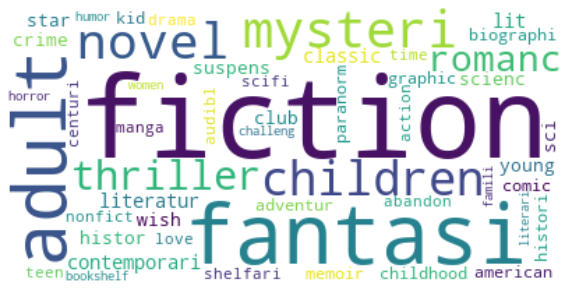

In [22]:
## plotting the most genres in the dataset

joined_text = ' '.join(tags_df['ptags'])

data = pd.Series(joined_text.split()).value_counts()[:50]

Cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(data)
plt.figure( figsize=(10,10) )
plt.imshow(Cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [23]:
## loading the ratings dataset
ratings_df = pd.read_csv('./ratings.csv', sep=',')
ratings_df.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [24]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   book_id  981756 non-null  int64
 1   user_id  981756 non-null  int64
 2   rating   981756 non-null  int64
dtypes: int64(3)
memory usage: 22.5 MB


In [25]:
ratings_df.isna().sum()

book_id    0
user_id    0
rating     0
dtype: int64

In [26]:
## plotting the distribution of ratings

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = ratings_df['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / ratings_df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of book-ratings',
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'), title_x=0.5)
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

number of books that had rates less than 100 times:  2544
number of books that had rates equal 100 times:  7456


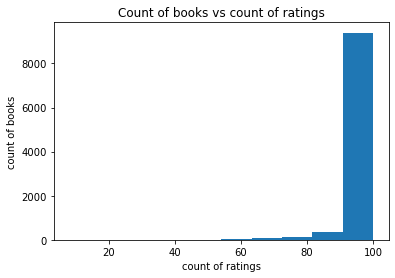

In [27]:
## number of ratings count for number books 
data = ratings_df.groupby('book_id')['rating'].count().sort_values(ascending= True)
print("number of books that had rates less than 100 times: " , len(data[data<100]))
print("number of books that had rates equal 100 times: " , len(data[data == 100]))
plt.hist(data)
plt.xlabel('count of ratings')
plt.ylabel('count of books')
plt.title('Count of books vs count of ratings')
plt.show()

In [28]:
## ratings by user -- # Group the dataset by users, calculate the average of rating 
# for each group on plot the average ratings 
# (x-axis: ratings from 1-5, y-axis: count of users with that average rating)

data = ratings_df.groupby('user_id')['rating'].mean()

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(size = 0.5))
# Create layout
layout = go.Layout(title = 'Distribution of Users per Average Rating',
                   xaxis = dict(title = 'Average Ratings Categories'),
                   yaxis = dict(title = 'Count of Users'),
                   bargap = 0.2, title_x=0.5)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [29]:
'''How many languages are there in the dataset? A plot of number of books per language is required here. 
Based on the plot, are there languages that you want to discard from your dataset?
'''
## first let's check the values of the languages

books_df["language_code"].value_counts()

eng      5608
en-US    2004
other    1003
en-GB     223
en-CA      52
ara        34
fre        24
spa        18
ind        16
ger        12
jpn         7
pol         5
nor         3
por         3
dan         3
fil         2
per         2
vie         1
nl          1
tur         1
swe         1
rum         1
mul         1
ita         1
Name: language_code, dtype: int64

In [30]:
## let's combine all english lang together

books_df["language_code"].replace(["en-US","en-GB","en-CA"],"eng", inplace=True)

In [31]:
data = books_df[books_df["language_code"] != 'other'].groupby('language_code')['book_id'].count()

# Create trace
trace = go.Bar(x = data.index, y = data.values)
# Create layout
layout = go.Layout(title = 'Number of Books per Language',
                   xaxis = dict(title = 'Languages'),
                   yaxis = dict(title = 'Count'), title_x=0.5)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [32]:
## Based on the plot, are there languages that you want to discard from your dataset?

## most of the books are in eng which might affect the recommendation engine not to recommend other tlanguages,
## however, taking down all the books with eng langauge would not fix the issue, Also,
## some langauges had one book each, these are not really contributing much into the recommendation process

In [33]:
## number of books by the author

data = books_df.groupby('authors')['book_id'].count().sort_values(ascending=False)[0:50]

# Create trace
trace = go.Bar(x = data.index, y = data.values)
# Create layout
layout = go.Layout(title = 'Number of Books per Author',
                   xaxis = dict(title = 'Authors'),
                   yaxis = dict(title = 'Count of Books'), title_x=0.5)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [34]:
# number of books that had authors that published more than or equal 20 books
print("number of authors",data.values.sum())
print("number of Authors who had published more than 20 books", data[data >= 20].sum())

number of authors 1234
number of Authors who had published more than 20 books 883


In [35]:
## Number of Books per Publication Year

data = books_df.groupby('original_publication_year')['book_id'].count().sort_values(ascending=False)

# Create trace
trace = go.Bar(x = data.index, y = data.values)
# Create layout
layout = go.Layout(title = 'Number of Books per Publication Year',
                   xaxis = dict(title = 'Years'),
                   yaxis = dict(title = 'Count of Books'), title_x=0.5)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [36]:
# number of books in the years where we had more than or equal 100 books
data[data >= 100].sum()

6805

In [37]:
'''Is there any difference between the average rating of the users 
    who rate more frequently than those who don’t?'''

user_rating_df = pd.DataFrame(ratings_df.groupby('user_id')['rating'].\
                    count()).reset_index().sort_values(by='user_id').rename(columns={"rating":"rating_count"})
user_rating_df["avg_rating"] = ratings_df.groupby('user_id')['rating'].mean()\
.reset_index().sort_values(by='user_id')['rating']

In [38]:
user_rating_df

,user_id,rating_count,avg_rating
0,1,3,3.666667
1,2,3,4.333333
2,3,2,1.000000
3,4,3,4.000000
4,5,5,4.200000
...,...,...,...
53419,53420,6,3.333333
53420,53421,8,5.000000
53421,53422,18,4.166667
53422,53423,2,5.000000


32498


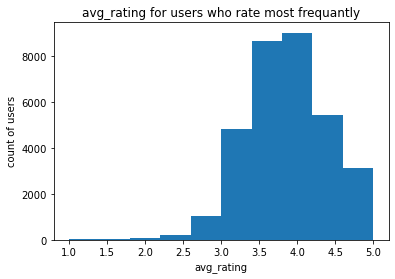

In [39]:
# the avg of avg_rating for users who rate most frequantly
mostFreRatedUsers = user_rating_df[user_rating_df["rating_count"] >5].sort_values(by='rating_count', ascending =True)
print(len(mostFreRatedUsers))
plt.hist(mostFreRatedUsers['avg_rating'])
plt.title('avg_rating for users who rate most frequantly')
plt.xlabel('avg_rating')
plt.ylabel('count of users')
plt.show()

20926


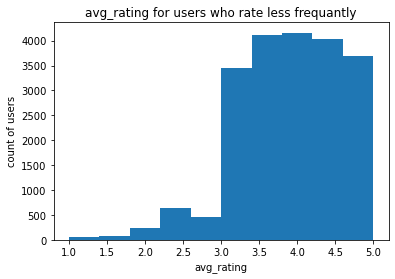

In [40]:
# the avg of avg_rating for users who rate less frequantly
leastFreRatedUsers = user_rating_df[user_rating_df["rating_count"] <=5].sort_values(by='rating_count', ascending =True)
print(len(leastFreRatedUsers))
plt.hist(leastFreRatedUsers["avg_rating"])
plt.title('avg_rating for users who rate less frequantly')
plt.xlabel('avg_rating')
plt.ylabel('count of users')
plt.show()

In [41]:
# the avg of avg_rating for users who rate most frequantly

user_rating_df.sort_values(by='rating_count', ascending =False)["avg_rating"][:1000].mean()

3.840817899164924

In [42]:
# the avg of avg_rating for users who rate less frequantly

user_rating_df.sort_values(by='rating_count', ascending =True)["avg_rating"][:1000].mean()

3.923

In [43]:
## the avg_rating seems to be for both most users who rate frequantly, users who dont is in the range of 3-5

## also, we can see that the users who rate less frequent tend to rate higher than who rate more frequantly.
## this is due to the fact that the users who rate less frequently, they lack the experience.
## for instance when they read a book they like, they instantly rate high rates for it

In [44]:
'''Based on the data, do you agree or disagree with the following hypothesis:
“if a book has many volumes it is more likely that is higher rating”.
Whether your answer is a yes or no explain why.
'''

'Based on the data, do you agree or disagree with the following hypothesis:\n“if a book has many volumes it is more likely that is higher rating”.\nWhether your answer is a yes or no explain why.\n'

In [45]:
vol_books_df = books_df[(books_df['title'].str.lower().str.contains('volume')\
         | books_df['title'].str.lower().str.contains('vol') | books_df['title'].str.lower().str.contains('#[0-9]') )]


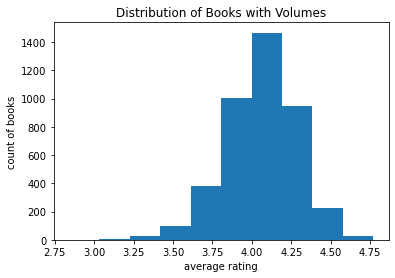

In [46]:
plt.hist(vol_books_df['average_rating'])
plt.xlabel('average rating')
plt.ylabel('count of books')
plt.title('Distribution of Books with Volumes')
plt.show()

In [47]:
no_vol_books_df = books_df[(~books_df['title'].str.lower().str.contains('volume')\
         & ~books_df['title'].str.lower().str.contains('vol')&\
                            ~books_df['title'].str.lower().str.contains('#[0-9]') )]

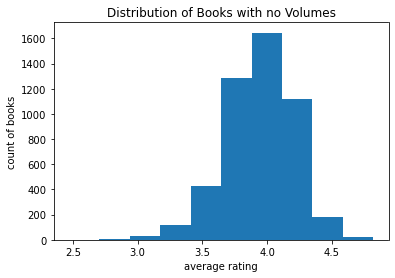

In [48]:
plt.hist(no_vol_books_df['average_rating'])
plt.xlabel('average rating')
plt.ylabel('count of books')
plt.title('Distribution of Books with no Volumes')
plt.show()

In [49]:
## Answer: The hypothesis is true, as we can see above the books with volumes had 
##slightly higher ratings than the books with no volumes

## Action Points

In [50]:
'''
To reduce the dimintionality of the data, we will filter out the data using the following action points:
1. filter out rarely rated users
2. filter out rarely rated books
3. drop the years where the number of published books is less than 100 rating times
'''

'\nTo reduce the dimintionality of the data, we will filter out the data using the following action points:\n1. filter out rarely rated users\n2. filter out rarely rated books\n3. drop the years where the number of published books is less than 100 rating times\n'

In [51]:
## filter out rarly rated users: any user who rated more than 5 times will be kept

mostFreRatedUsers = user_rating_df[user_rating_df["rating_count"] >5].sort_values(by='rating_count', ascending =True)
rating_df_new =  pd.merge(mostFreRatedUsers[['user_id']], ratings_df, on='user_id', how='inner')
rating_df_new

,user_id,book_id,rating
0,25758,6110,5
1,25758,6971,4
2,25758,7192,4
3,25758,7425,3
4,25758,7992,4
...,...,...,...
916875,12874,4974,4
916876,12874,4999,2
916877,12874,5437,4
916878,12874,6768,4


number of books that had rates less than 100 times:  2544
number of books that had rates equal 100 times:  7456


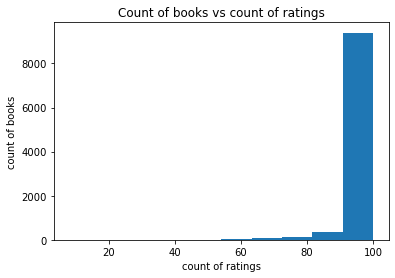

In [52]:
## filtering out the rarely rated books
books_ratings_count = ratings_df.groupby('book_id')['rating'].count().sort_values(ascending= True)
print("number of books that had rates less than 100 times: " , len(books_ratings_count[books_ratings_count<100]))
print("number of books that had rates equal 100 times: " , len(books_ratings_count[books_ratings_count == 100]))
plt.hist(books_ratings_count)
plt.xlabel('count of ratings')
plt.ylabel('count of books')
plt.title('Count of books vs count of ratings')
plt.show()

In [53]:
## now we will keep the books that have the most rating counts,
##and with puplication year where the year had more than 100 books published in it
years_with_mostBooks = pd.DataFrame(books_df.groupby(['original_publication_year'])['book_id'].count())\
.reset_index().rename(columns={"book_id": "books_count"}) ## creating a df grouped based on Publication year

years_with_mostBooks = pd.merge(years_with_mostBooks, books_df[['original_publication_year', 'book_id']], 
                               on='original_publication_year', how='inner') ## add the book_id to the dataframe


most_years_booksRatings_joined = pd.merge(years_with_mostBooks[years_with_mostBooks["books_count"]>100], \
         pd.DataFrame(books_ratings_count[books_ratings_count==100].keys()),\
         on='book_id', how='left') ## adding the constraints to the above dataframes and joining them
most_years_booksRatings_joined[["book_id"]]

,book_id
0,32499
1,5203
2,830
3,5364
4,29044
...,...
6800,25671827
6801,25614984
6802,25813921
6803,22062202


In [54]:
## adding the actions points on the ratings dataset (action points 2, and 3)
rating_df_new =  pd.merge(most_years_booksRatings_joined[['book_id']], rating_df_new, on='book_id', how='inner')
## affecting the original books dataframe so we can have only the books that we need
books_df_new = pd.merge(rating_df_new[['book_id']], books_df, on='book_id', how='inner')
rating_df_new

,book_id,user_id,rating
0,5203,18384,4
1,5203,49870,5
2,5203,1278,3
3,5203,15060,4
4,5203,16789,4
...,...,...,...
39269,1635,39423,3
39270,1635,12455,5
39271,1635,45493,5
39272,1635,21676,4


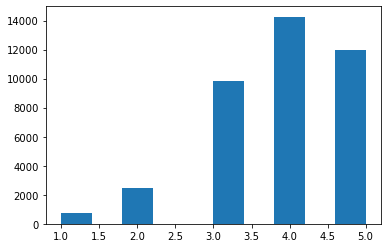

In [55]:
## let's check the distribution of the ratings after the filteration is done

plt.hist(rating_df_new["rating"])
plt.show()

In [56]:
## as we can see the difference in the ratings distribution after the filteration is done, as we had so 
#many rarly rated books and rarly rated users where they were affecting the dimintionality of the dataset

## Building the Recommendation Engine

In [68]:
from surprise import Reader
from surprise import KNNWithMeans, KNNBasic, KNNBaseline, KNNWithZScore
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

In [69]:
reader = Reader(rating_scale=(1, 5))

rating_df_new_1 = Dataset.load_from_df(rating_df_new[["user_id", "book_id", "rating"]], reader)

In [70]:
rating_df_new_1

In [60]:
# sim_options = {
#     "name": [ "pearson_baseline"],
#     "min_support": [3, 5],
#     "user_based": [True,False],
# }

# param_grid = {"sim_options": sim_options, "K": [5,10]}

# gs = GridSearchCV(KNNWithMeans, param_grid, measures=["rmse", "mae"], cv=3)
# gs.fit(rating_df_new_1)

# print(gs.best_score["rmse"])
# print(gs.best_params["rmse"])

In [61]:
## we ran the above cell on google colab as it takes a lot of resources to run the hyper parameter tunning.
## after running the tunning we ended up with the following params

In [71]:
trainset, testset = train_test_split(rating_df_new_1, test_size=.2)

In [72]:

recsys = KNNBaseline(k=5, sim_options={'name': 'pearson_baseline', 'user_based': True, 'min_support': 5})
recsys.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [73]:
predictions = recsys.test(testset)

In [74]:
predictions

[Prediction(uid=31198, iid=360, r_ui=5.0, est=3.7955879656478153, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=45696, iid=7061, r_ui=4.0, est=3.9564675397704456, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=11014, iid=2002, r_ui=3.0, est=3.8342114634254383, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=32845, iid=2517, r_ui=4.0, est=3.6658356702896557, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=45014, iid=6614, r_ui=5.0, est=4.01277546890374, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=40194, iid=2002, r_ui=5.0, est=3.8118277027187424, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=3537, iid=3985, r_ui=4.0, est=3.726604106407105, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=9668, iid=597, r_ui=2.0, est=3.664329056386255, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid=17800, iid=5346, r_ui=5.0, est=4.431605796155826

In [75]:
from surprise import accuracy

In [76]:
# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9298


0.9298175619415887

## Thank You!